### The steps will be as follows: -
1. Reading, understanding and visualizing the data
2. Preparing the data for modelling (train-test split, rescaling etc.)
3. Training the model
4. Residual analysis
5. Predictions and evaluation on the test set

## Step-1: Reading, understanding and visualizing the data

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the data
# Output Variable - PE
# Predictor variables - AT, V, AP & RH
ccpp_data = pd.read_csv("Folds5x2_pp.csv")
ccpp_data.head()

AT      V       AP     RH      PE
0   8.34  40.77  1010.84  90.01  480.48
1  23.64  58.49  1011.40  74.20  445.75
2  29.74  56.90  1007.15  41.91  438.76
3  19.07  49.69  1007.22  76.79  453.09
4  11.80  40.66  1017.13  97.20  464.43

In [3]:
# size of data
ccpp_data.shape

(9568, 5)

In [4]:
# to check for missing values
ccpp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [5]:
# to check for missing values
ccpp_data.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [6]:
# for statistical summary
ccpp_data.describe()

AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000

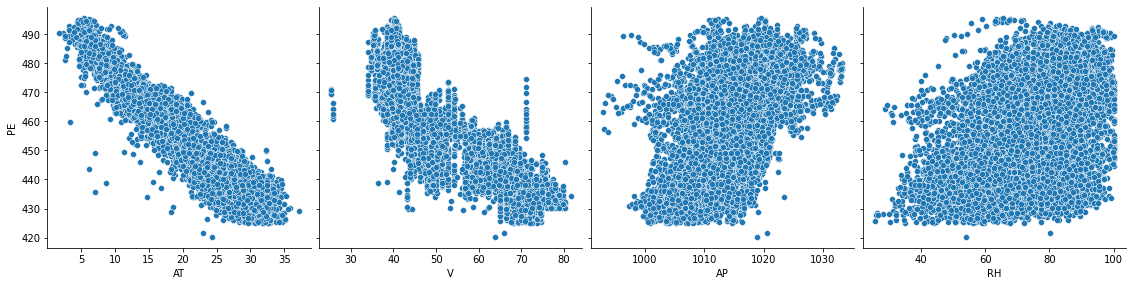

In [7]:
# visualize the data
# Assumption 1 - There should be linear relationship between dependent and independent variable
# As can be seen through scatter plot of output variable (PE) and independent variables (AT, V, AP & RH),
# data looks like it can roughly fit a line, therefore, we can perform linear regression.
# Scatter plot validates assumption of linearity
sns.pairplot(ccpp_data, x_vars=['AT', 'V', 'AP', 'RH'], y_vars='PE',size=4, aspect=1, kind='scatter')
plt.show()

## Step-2: Preparing the data for modelling (train-test split, rescaling etc.)

In [8]:
# train-test split
df_train, df_test = train_test_split(ccpp_data, train_size=0.70, random_state=100)
print(df_train.shape)
print(df_test.shape)

(6697, 5)
(2871, 5)


#### Rescaling the Features

In [9]:
# 1. Instantiate an object
scaler = MinMaxScaler()

# create a list of numeric vars
num_vars = ['AT', 'V', 'AP', 'RH', 'PE']


# 2. Fit on data
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

AT         V        AP        RH        PE
3466  0.769435  0.670996  0.441970  0.174397  0.224912
8410  0.804770  0.748932  0.559762  0.280295  0.116490
4481  0.848351  0.732740  0.277654  0.399464  0.055202
6776  0.490577  0.653737  0.667409  0.764209  0.387827
2167  0.366019  0.346619  0.759960  0.918231  0.588252

## Step-3: Training the Model

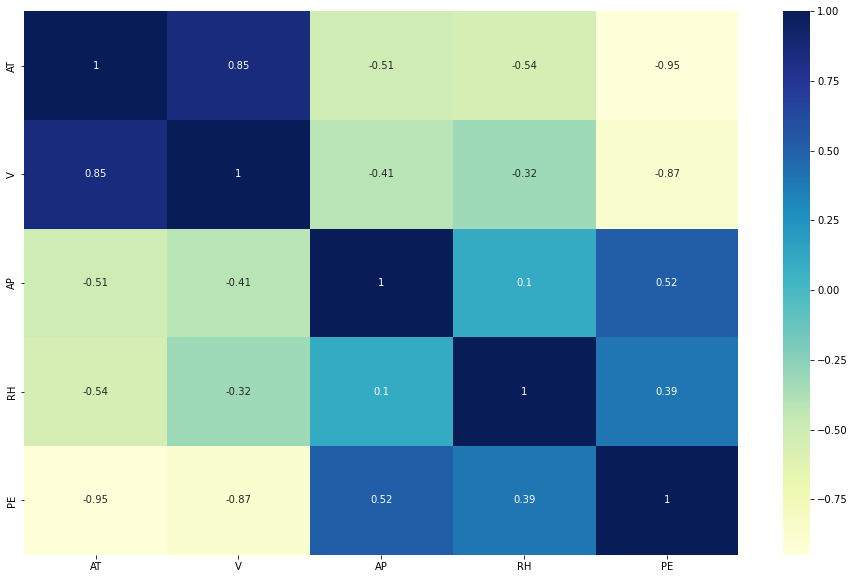

In [10]:
# heatmap of correlation values on training set
plt.figure(figsize = (16,10))
sns.heatmap(df_train.corr(), annot = True, cmap='YlGnBu')

plt.show()

# There is negative correlation between (PE, AT) and (PE, V). 
# Also, there is positive correlation between (PE, AP) and (PE, RH)
# Therefore, we can use linear regression

#### Adding all Variables to the Model

In [11]:
# all column list
ccpp_data.columns

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

In [12]:
# X_train - All the columns apart from PE
# y_train - PE
y_train = df_train.pop('PE')
X_train = df_train

In [13]:
# build a model with all variables
X_train_sm = sm.add_constant(X_train)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 2.201e+04
Date:                Tue, 26 Jul 2022   Prob (F-statistic):               0.00
Time:                        22:40:54   Log-Likelihood:                 8867.5
No. Observations:                6697   AIC:                        -1.773e+04
Df Residuals:                    6692   BIC:                        -1.769e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0973      0.007    148.413      0.0

In [14]:
# Need to check significance (p-values) & VIF
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

Features    VIF
1        V  23.80
0       AT  22.45
3       RH   8.03
2       AP   7.98

In [15]:
# remove V (having highest VIF - 23.80)
X = X_train.drop('V', axis=1)

In [16]:
# create another model
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                 2.622e+04
Date:                Tue, 26 Jul 2022   Prob (F-statistic):               0.00
Time:                        22:40:54   Log-Likelihood:                 8517.4
No. Observations:                6697   AIC:                        -1.703e+04
Df Residuals:                    6693   BIC:                        -1.700e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1447      0.008    151.207      0.0

In [17]:
# Calculate the VIFs again for the new model
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

Features   VIF
1       AP  7.92
2       RH  7.49
0       AT  3.43

In [18]:
# remove AP (having highest VIF - 7.92 and p-value - 0.064)
X = X.drop('AP', axis=1)

In [19]:
# create another model
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                 3.932e+04
Date:                Tue, 26 Jul 2022   Prob (F-statistic):               0.00
Time:                        22:40:54   Log-Likelihood:                 8515.7
No. Observations:                6697   AIC:                        -1.703e+04
Df Residuals:                    6694   BIC:                        -1.700e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1552      0.005    231.458      0.0

In [20]:
# Calculate the VIFs again for the new model
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

Features   VIF
0       AT  3.06
1       RH  3.06

## Step-4: Residual analysis

In [21]:
# predicted value on training set
y_train_pred = lr_model.predict(X_train_sm)

# residual of training set
res = y_train - y_train_pred

In [22]:
# Assumption 2 - Mean of the residuals should be zero
mean_residuals = np.mean(res)
print("Mean of Residuals {}".format(mean_residuals))

# Mean is very close to zero

Mean of Residuals -9.676778151695883e-16


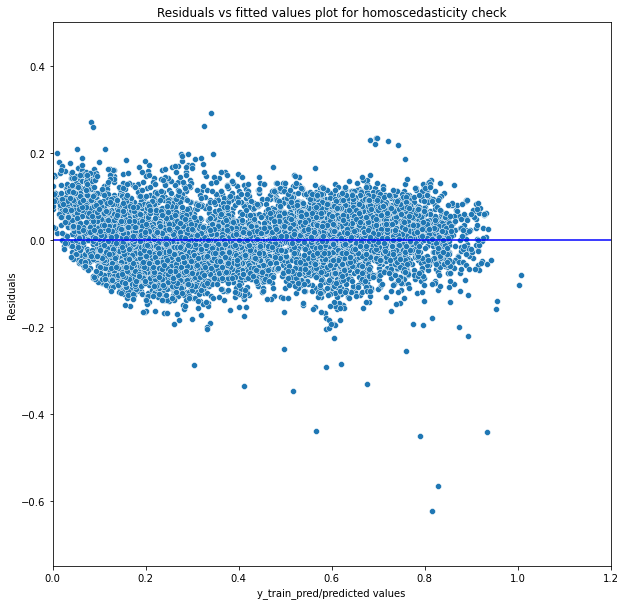

In [23]:
# Assumption 3 - Check for Homoscedasticity
plt.figure(figsize=(10,10))
p = sns.scatterplot(y_train_pred,res)
plt.xlabel('y_train_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-0.75,0.5)
plt.xlim(0,1.2)
p = sns.lineplot([0,1.2],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

# It can be seen there is no definite pattern in the scatter plot, therefore, heteroscedasticity is not present

<AxesSubplot:ylabel='Density'>

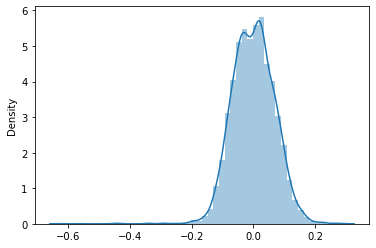

In [24]:
# Assumption 4 - Check for Normality of error terms/residuals
# dist plot of residuals
sns.distplot(res)

# It can be seen, the distribution is centered around zero and it is approximatey normal

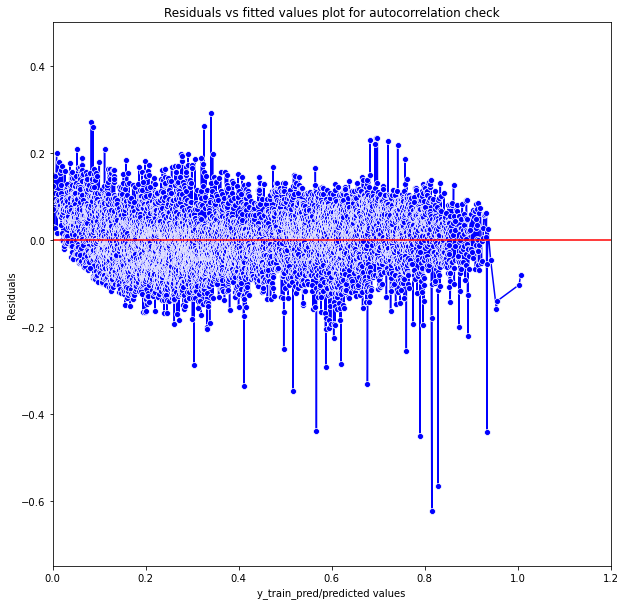

In [25]:
# Assumption 5 - No autocorrelation of residuals

plt.figure(figsize=(10,10))
p = sns.lineplot(y_train_pred,res, marker='o',color='blue')
plt.xlabel('y_train_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-0.75,0.5)
plt.xlim(0,1.2)
p = sns.lineplot([0,1.2],[0,0],color='red')
p = plt.title('Residuals vs fitted values plot for autocorrelation check')

# It can be seen that the error terms are not forming any pattern

## Step-5: Predictions and Evaluation on the Test Set

In [26]:
# create a list of numeric vars
num_vars = ['AT', 'V', 'AP', 'RH', 'PE']

# 2. Fit on data
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

AT         V        AP        RH        PE
2708  0.541814  0.601068  0.571888  0.600804  0.335173
6408  0.749117  0.793950  0.387528  0.455630  0.089597
435   0.687574  0.924199  0.194011  0.815550  0.201840
5777  0.673145  0.761210  0.298688  0.436863  0.188110
2863  0.131037  0.283808  0.226429  0.830831  0.855768

In [27]:
# for statistical summary of test set
df_test.describe()

AT            V           AP           RH           PE
count  2871.000000  2871.000000  2871.000000  2871.000000  2871.000000
mean      0.524368     0.510865     0.504081     0.641290     0.416193
std       0.218035     0.225160     0.147348     0.194647     0.240020
min       0.015607     0.000000     0.021034     0.009920    -0.068648
25%       0.342314     0.289680     0.399654     0.505764     0.209483
50%       0.544464     0.463879     0.495669     0.663941     0.379193
75%       0.703180     0.731673     0.602450     0.793432     0.611111
max       1.039458     0.975445     0.999753     0.999866     0.992498

In [28]:
# X_test & y_test
y_test = df_test.pop('PE')
X_test = df_test

In [29]:
# add a constant
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

const        AT         V        AP        RH
2708    1.0  0.541814  0.601068  0.571888  0.600804
6408    1.0  0.749117  0.793950  0.387528  0.455630
435     1.0  0.687574  0.924199  0.194011  0.815550
5777    1.0  0.673145  0.761210  0.298688  0.436863
2863    1.0  0.131037  0.283808  0.226429  0.830831

In [30]:
# Drop V and AP
X_test_sm = X_test_sm.drop(['V', 'AP'], axis = 1)

In [31]:
# predicted value on test set
y_test_pred = lr_model.predict(X_test_sm)

In [32]:
# evaluate r2 score of test set
r2_score(y_true=y_test, y_pred=y_test_pred)

# r2 score is 0.919 on the test set and also, r2 score was 0.922 on the training set
# Both are quite close, therefore, we can say whatever the model learnt on the training set,
# we are able to generalize that on the test set as well

0.9194923210462185

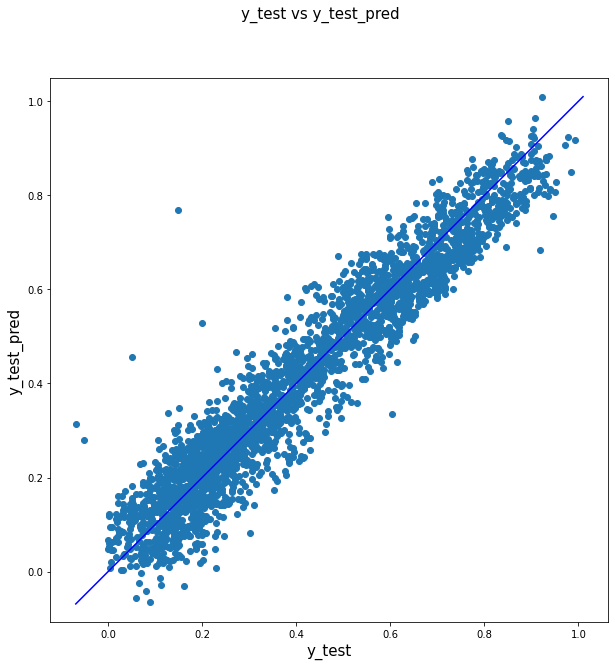

In [33]:
# Finally, Plotting y_test and y_test_pred to understand the spread

fig = plt.figure(figsize=(10,10))
plt.scatter(y_test, y_test_pred)

p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
fig.suptitle('y_test vs y_test_pred', fontsize = 15)              
plt.xlabel('y_test', fontsize=15)
plt.ylabel('y_test_pred', fontsize=15)
plt.axis('equal')
plt.show()

Hence, equation for Energy Output is 
PE = 1.1552 - 1.1489 × AT - 0.2158 × RH